# 4.4 Low-Dimensional Embedding For Dirichlet-Multinomial Data

In [1]:
import numpy as np
import torch
import torch.nn as nn
import math
import matplotlib.pyplot as plt
from scipy.special import psi
import random
from sklearn.model_selection import train_test_split


In [2]:
eps = torch.finfo(torch.float64).eps

In [38]:
def criterion_dirichlet_multinomial(alpha, beta, target):
    """
    alpha and beta are of shape (N, d)
    target is of shape (N, d + 1)
    """
    alpha_prime = alpha + target[:, :-1]
    d = alpha.shape[1]
    
    # beta_prime = beta.clone().detach()
    # for l in range(0, d):
    #     beta_prime[:, l] += torch.sum(target[:, l+1:d+1], dim=1)
        
    beta_prime = torch.empty_like(beta)
    # beta_prime = beta.detach().clone()
    for l in range(0, d):
        beta_prime[:, l] = beta[:, l]
        beta_prime[:, l] += torch.sum(target[:, l+1:d+1], dim=1)
    
    # print("alpha", alpha)
    # print("beta", beta)
    # print("alpha + beta", alpha + beta)
    # print("target", target)
    # print("alpha_prime", alpha_prime)
    # print("beta_prime", beta_prime)
    
    return   -(torch.lgamma(torch.sum(target, dim=1) + 1 + eps) - torch.sum(torch.lgamma(target + 1 + eps)) \
           + torch.sum(torch.lgamma(alpha + beta + eps), dim=1) - torch.sum(torch.lgamma(alpha_prime + beta_prime + eps), dim=1) \
           + torch.sum(torch.lgamma(alpha_prime + eps), dim=1) - torch.sum(torch.lgamma(alpha + eps), dim=1) \
           + torch.sum(torch.lgamma(beta_prime + eps), dim=1) - torch.sum(torch.lgamma(beta + eps), dim=1)).mean()

In [4]:
torch.use_deterministic_algorithms(True)
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [5]:
num_dim = 100
num_clusters = 10
num_samples_per_cluster = 1000

In [6]:
alpha = (0.1, ) * num_dim

In [7]:
X = np.zeros((num_clusters * num_samples_per_cluster, num_dim))
y = np.zeros((num_clusters * num_samples_per_cluster, ))

In [8]:
for i in range(num_clusters):
    n = math.floor(np.random.uniform(50, 100, 1))
    p = np.random.dirichlet(alpha, 1)[0]
    X[i * num_samples_per_cluster : (i + 1) * num_samples_per_cluster, :] = np.random.multinomial(n, p, size=num_samples_per_cluster)
    y[i * num_samples_per_cluster : (i + 1) * num_samples_per_cluster] = i

In [9]:
X_tensor = torch.tensor(X, dtype=torch.float64)
y_tensor = torch.tensor(y, dtype=torch.int32)

In [10]:
print(X_tensor)

tensor([[1., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [2., 0., 0.,  ..., 1., 0., 0.],
        [4., 0., 0.,  ..., 0., 0., 0.],
        [3., 0., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)


In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

In [12]:
dataset_train = torch.utils.data.TensorDataset(X_train, Y_train)
dataset_test = torch.utils.data.TensorDataset(X_test, Y_test)
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=32, shuffle=True)

In [13]:
class IL(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        eps = 1e-6
        return torch.where(x < 0, (1 / (1 - x)) + eps, x + 1 + eps)

In [14]:
class EL(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return torch.nn.functional.elu(x) + 1

In [36]:
def plot_latent(autoencoder, data, label, figname):
    encoded = model.encoder(data).detach().numpy()
    plt.scatter(encoded[:, 0], encoded[:, 1], c=label.detach().numpy())
    plt.colorbar()
    plt.savefig(figname, format='eps')

In [16]:
batch_size = 100
n_epochs = 100

In [17]:
class AutoEncoderBaseline(nn.Module):
    def __init__(self, num_input=100, num_bottleneck=2):
        super(AutoEncoderBaseline, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(num_input, 100, dtype=torch.float64),
            nn.ReLU(True),
            nn.Linear(100, 64, dtype=torch.float64),
            nn.ReLU(True), nn.Linear(64, 12, dtype=torch.float64), nn.ReLU(True), nn.Linear(12, num_bottleneck, dtype=torch.float64))
        self.decoder = nn.Sequential(
            nn.Linear(num_bottleneck, 12, dtype=torch.float64),
            nn.ReLU(True),
            nn.Linear(12, 64, dtype=torch.float64),
            nn.ReLU(True),
            nn.Linear(64, 100, dtype=torch.float64),
            nn.ReLU(True), nn.Linear(100, num_input, dtype=torch.float64))

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [18]:
model = AutoEncoderBaseline()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [19]:
print(model)

AutoEncoderBaseline(
  (encoder): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=100, out_features=64, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=12, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=12, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=12, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=12, out_features=64, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=100, out_features=100, bias=True)
  )
)


In [20]:
for epoch in range(1, n_epochs + 1):
    for i, (data, label) in enumerate(train_loader):
        output = model(data)
        loss = criterion(output, data)
        if i == 0:
            # print(output)
            # print(X_batch)
            print(f"Epoch {epoch}: loss: {loss.item()}")
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

Epoch 1: loss: 7.236833744161157
Epoch 2: loss: 5.850073541173032
Epoch 3: loss: 4.889087691001254
Epoch 4: loss: 4.042824696592243
Epoch 5: loss: 3.6149367461806943
Epoch 6: loss: 3.2232162836093585
Epoch 7: loss: 2.83503614468499
Epoch 8: loss: 2.4133182884734907
Epoch 9: loss: 2.1280788289121237
Epoch 10: loss: 1.9248276715715316
Epoch 11: loss: 1.7367494801807783
Epoch 12: loss: 1.5388407835970788
Epoch 13: loss: 1.3424327754094219
Epoch 14: loss: 1.1650970461922787
Epoch 15: loss: 1.0312033373599225
Epoch 16: loss: 0.9367485125071139
Epoch 17: loss: 0.8684451440355191
Epoch 18: loss: 0.8211634561062237
Epoch 19: loss: 0.7879807900644025
Epoch 20: loss: 0.7643049557608558
Epoch 21: loss: 0.7470961386628037
Epoch 22: loss: 0.7339195804176848
Epoch 23: loss: 0.7233683932159614
Epoch 24: loss: 0.7143184128351802
Epoch 25: loss: 0.7063983617656265
Epoch 26: loss: 0.6990282563635247
Epoch 27: loss: 0.6924605054571173
Epoch 28: loss: 0.6856941993147013
Epoch 29: loss: 0.6805072683229594


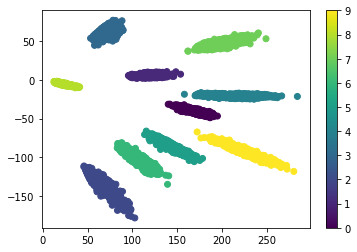

In [21]:
plot_latent(model, X_train, Y_train)

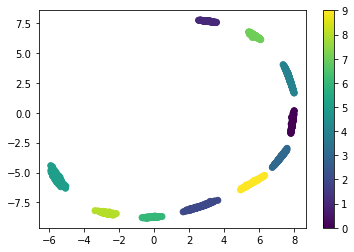

In [37]:
plot_latent(model, X_test, Y_test, "baseline.eps")

In [23]:
class AutoEncoder(nn.Module):
    def __init__(self, num_input=100, num_bottleneck=2):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(num_input, 64, dtype=torch.float64),
            nn.Tanh(),
            nn.Linear(64, 12, dtype=torch.float64),
            nn.Tanh(),
            nn.Linear(12, num_bottleneck, dtype=torch.float64)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(num_bottleneck, 12, dtype=torch.float64),
            nn.Tanh(),
            nn.Linear(12, 64, dtype=torch.float64),
            nn.Tanh()
        )
        
        self.GeneralizedDirichletMultinomialAlpha = nn.Sequential(
        nn.Linear(64, num_input - 1, dtype=torch.float64),
        EL()
        )
        
        self.GeneralizedDirichletMultinomialBeta = nn.Sequential(
        nn.Linear(64, num_input - 1, dtype=torch.float64),
        EL()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        alpha = self.GeneralizedDirichletMultinomialAlpha(decoded)
        beta = self.GeneralizedDirichletMultinomialBeta(decoded)
        return alpha, beta

In [32]:
num_bottleneck = 2
model = AutoEncoder(num_dim, num_bottleneck)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [33]:
for epoch in range(1, n_epochs + 1):
    for i, (data, label) in enumerate(train_loader):        
        alpha, beta = model(data)
        loss = criterion_dirichlet_multinomial(alpha, beta, data)
        if i == 0:
            print(f"Epoch {epoch}: loss: {loss.item()}")
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

Epoch 1: loss: 3278.0119655817825
Epoch 2: loss: 3103.8475534695367
Epoch 3: loss: 3047.7740576262486
Epoch 4: loss: 3038.916611812315
Epoch 5: loss: 3036.813278654325
Epoch 6: loss: 3036.018580771418
Epoch 7: loss: 3035.5865890869973
Epoch 8: loss: 3035.290976064722
Epoch 9: loss: 3035.0625575656704
Epoch 10: loss: 3034.8741943520836
Epoch 11: loss: 3034.710405026411
Epoch 12: loss: 3034.561091780265
Epoch 13: loss: 3034.4134811424747
Epoch 14: loss: 3034.2515405615104
Epoch 15: loss: 3034.0693906636598
Epoch 16: loss: 3033.8522771219177
Epoch 17: loss: 3033.5008906690146
Epoch 18: loss: 3033.1024472314025
Epoch 19: loss: 3032.395244037215
Epoch 20: loss: 3031.182835718174
Epoch 21: loss: 3029.6504982078773
Epoch 22: loss: 3028.4313165881017
Epoch 23: loss: 3027.585328245325
Epoch 24: loss: 3026.949511185583
Epoch 25: loss: 3026.402435014278
Epoch 26: loss: 3025.877159411463
Epoch 27: loss: 3025.3388569021854
Epoch 28: loss: 3024.785468241754
Epoch 29: loss: 3024.218623985109
Epoch 30

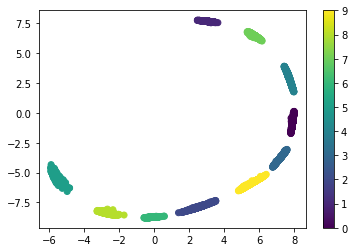

In [34]:
plot_latent(model, X_train, Y_train)

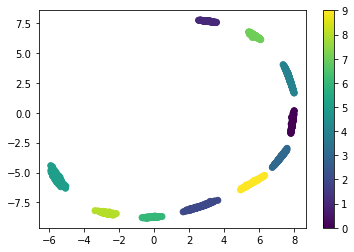

In [35]:
plot_latent(model, X_test, Y_test)